In [6]:
import tensorflow as tf
import tensorflow_hub as hub

In [23]:
import torch
from torchvision import models, transforms

In [46]:
from PIL import Image
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [9]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-czy0tx05
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-czy0tx05
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440311 sha256=eab7970d8630eb8cc78269546012ee916de18a6125bef8a9476d9073e6bb29a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-14pnpdt_/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


In [10]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels

In [24]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 169MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [26]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std  = [0.229, 0.224, 0.225])
])

In [141]:
img = Image.open("outfocusing.png").convert("RGB")

In [42]:
def preprocessing(img, scale):
  img_np=np.array(img)
  h, w= img_np.shape[:2]
  new_h, new_w = int(h*scale), int(w*scale)
  img_np=cv2.resize(img_np, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
  img_pil = Image.fromarray(img_np)
  input_tensor = transform(img_pil).unsqueeze(0)

  return input_tensor, (new_h, new_w)

In [115]:
def inference_scale2(model,img, scales=[1.0,0.5,1.5]):
  softmax_maps =[]
  base=0

  for scale in scales:
    img_tensor, new_shape = preprocessing(img, scale)
    if scale == 1:
      base = new_shape

    with torch.no_grad():
      logits= model(img_tensor)['out']

    logits_resize=F.interpolate(logits, size=(base[0],base[1]), mode='bilinear',align_corners=False)
    softmax_map = torch.softmax(logits_resize, dim=1)
    softmax_maps.append(softmax_map)

  avg_softmax = torch.mean(torch.stack(softmax_maps, dim=0), dim=0)
  label_map = torch.argmax(avg_softmax, dim=1).squeeze().cpu().numpy().astype(np.uint8)

  return label_map

In [79]:
def inference_scale(model,img, threshold=0.8,scales=[1.0,0.5,1.5]):
  softmax_maps =[]
  base=0

  for scale in scales:
    img_tensor, new_shape = preprocessing(img, scale)
    if scale == 1:
      base = new_shape

    with torch.no_grad():
      logits= model(img_tensor)['out']

    logits_resize=F.interpolate(logits, size=(base[0],base[1]), mode='bilinear',align_corners=False)

    softmax_map = torch.softmax(logits_resize, dim=1)
    softmax_maps.append(softmax_map)

  avg_softmax = torch.mean(torch.stack(softmax_maps, dim=0), dim=0)
  foreground_class = [15, 3, 8, 10, 12, 13, 17]
  foreground_prob = avg_softmax[0,foreground_class, :, :].sum(dim=0)
  label_map = (foreground_prob > threshold).cpu().numpy().astype(np.uint8)

  return label_map

In [142]:
label_map=inference_scale2(model,img)

In [81]:
label_map.shape

(450, 800)

In [163]:
foreground_class = [15, 3, 8, 10, 12, 13, 17]
foreground_mask = np.isin(label_map, foreground_class)

In [104]:
foreground_mask=label_map

In [76]:
def refine_mask_crf(image, binary_mask, num_classes=2, bilateral_sxy=(10, 10), bilateral_srgb=(13, 13, 13), compat_bilateral=10, iteration=6, prior=0.7):
    H, W = binary_mask.shape

    d = dcrf.DenseCRF2D(W, H, num_classes)

    labels = binary_mask.astype(np.uint8)

    # GT 기반 unary 생성
    unary = unary_from_labels(labels, n_labels=num_classes, gt_prob=prior, zero_unsure=False)
    d.setUnaryEnergy(unary)

    # Edge-aware term (Bilateral)
    d.addPairwiseBilateral(sxy=bilateral_sxy, srgb=bilateral_srgb,
                           rgbim=image, compat=compat_bilateral)

    # CRF inference (mean-field approximation)
    Q = d.inference(iteration)  # 5~10 iteration 정도면 충분

    # 결과는 확률 → 가장 확률 높은 클래스로 결정
    refined = np.argmax(Q, axis=0).reshape((H, W)).astype(np.uint8)

    return refined

In [164]:
refine_mask=refine_mask_crf(np.array(img),foreground_mask)

In [84]:
refine_mask.shape

(450, 800)

In [145]:
refine_mask=label_map

In [61]:
def soft_mask(binary_mask, blur_kernel=(31, 31), sigma=0):
    mask = binary_mask.astype(np.float32)
    blurred = cv2.GaussianBlur(mask, blur_kernel, sigmaX=sigma, sigmaY=sigma)
    soft_mask = np.clip(blurred, 0.0, 1.0)

    return soft_mask

In [62]:
def make_sharpen(image, strength=0.8):
  image=np.array(image).astype(np.float32)/255.0
  blurred=cv2.GaussianBlur(image, (0,0), sigmaX=3)
  sharpened=cv2.addWeighted(image,1+strength,blurred,-strength,0)
  return sharpened

In [63]:
def make_blur(image, kernel=(31,31), sigma=0):
  image=np.array(image).astype(np.float32)/255.0
  return cv2.GaussianBlur(image,kernel,sigmaX=sigma,sigmaY=sigma)

In [64]:
def outfocusing(image, binary_mask):
  alpha=soft_mask(binary_mask)
  sharpened=make_sharpen(image)
  blurred=make_blur(image)

  result = alpha[..., None] * sharpened + (1 - alpha[..., None]) * blurred
  output = np.clip(result*255,0,255).astype(np.uint8)
  return output

In [146]:
output=outfocusing(img,refine_mask)

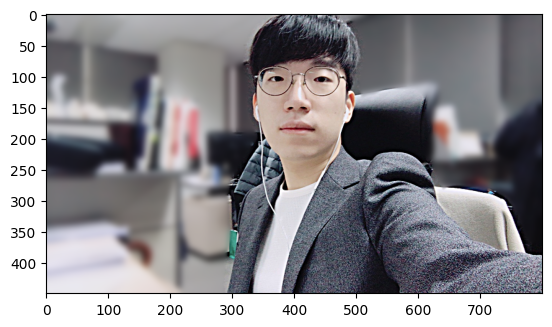

In [147]:
plt.imshow(output)
plt.show()

###2.분석

위 방법에서 조절할 수 있는 옵션은 사람인지를 판단하는 threshold, CRF 보정옵션 5개, mask, image 의 sharpen과 blur를 조정하는 옵션 4개이다.

모델을 바꾸지 않는 한 목 부분의 outfoucsing은 경계선만 개선될 뿐 큰 변화가 어렵다.

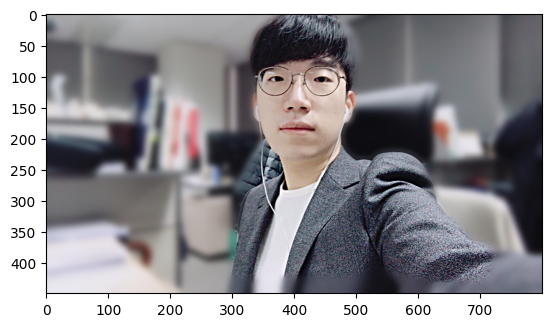

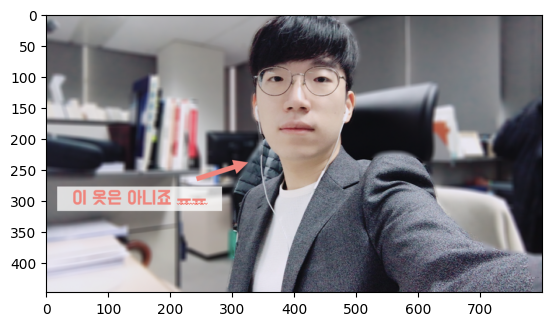

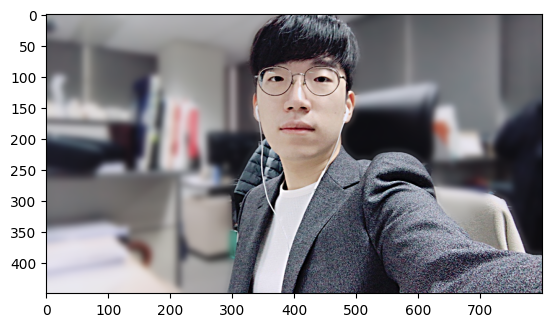

즉 위 3개의 사진과 같이 후처리 등으로 잘못 분류된 픽셀의 경계를 보정할 수 있지만 그 부분만 보정할 수 있는 것이 아니기 때문에 파라미터 조절에서 최적을 찾을 수는 있겠지만 한계가 있다.

outfocusing의 문제점
1. 전체적으로 흐릿해지는점
2. 배경이 아닌것이 배경으로 분류되서 blur
3. 전경이 아닌것이 전경으로 분류되서 sharpen

1. multi scaling - 이미지를 다른 사이즈로 모델에 넣어서 로짓차원에서 다시 resize한 후 softmax 결과인 확률을 평균내어 semantic classification의 정확도 보정
2. foreground에 해당하는 확률을 다 더한 후 threshold를 넘는 것만 그 클래스로 분류하는 것으로 전경 기준을 까다롭게 적용
3. CRF 를 적용하여 위치와 색이 비슷하면 같은 클래스로 하는 알고리즘을 도입하여 mask의 경계 보정
4. binary mask를 gaussian blur를 적용하여 전경과 배경이 자연스럽게 넘어가도록 함
5. sharpen과 blur image를 mask를 통하여 blendding하여 전경은 더욱 또렷하게 하여 이미지를 부각

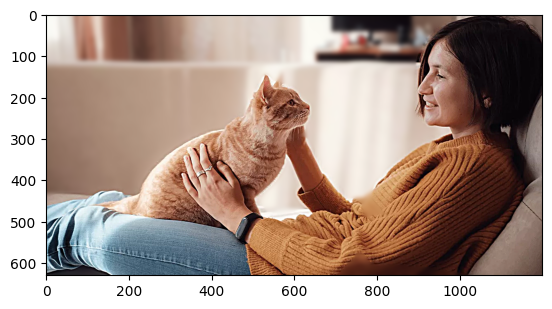

동물사진도 제시하였다.

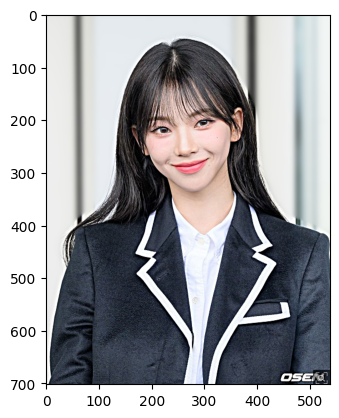

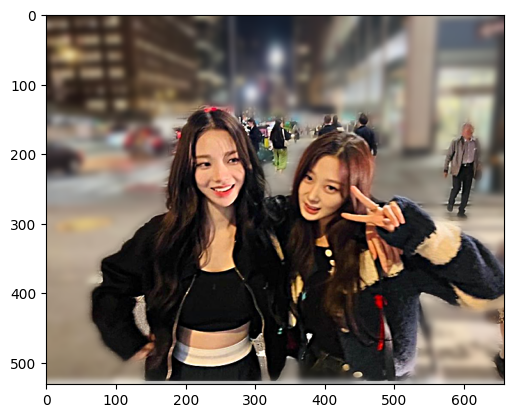

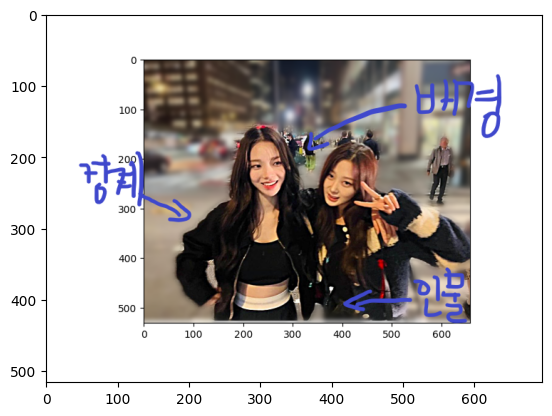

다음과 같이 문제를 지적하였다.

크로마키

In [148]:
background= Image.open('background.jpg').convert("RGB")

In [150]:
img_np=np.array(img).astype()
back_np=np.array(background)

In [166]:
H, W = img_np.shape[:2]
back_resize = cv2.resize(back_np, (W, H), interpolation=cv2.INTER_LINEAR)

# 2. 마스크 확장: [H, W] → [H, W, 3] for broadcasting
mask_3ch = np.repeat(refine_mask[:, :, np.newaxis], 3, axis=2)

# 3. 크로마키 합성: 전경은 마스크 1, 배경은 0
output = img_np* mask_3ch + back_resize * (1 - mask_3ch)
output = output.astype(np.uint8)

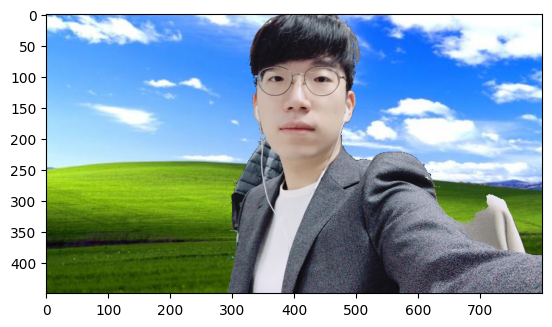

In [167]:
plt.imshow(output)
plt.show()

후기

크로마키에 지적한 사진까지 제출하라는 점이 귀찮았다.